In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv3D, Dense, Flatten, GlobalAveragePooling2D, Conv2D, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.backend import sum
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, AveragePooling3D, Reshape,Dense,AveragePooling2D,GlobalAveragePooling2D, GlobalAveragePooling3D, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Lambda, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import rmsprop, adam
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.utils import plot_model

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

In [6]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [7]:
h5f = h5py.File('D:/total_data_ro.h5','r')
#data = h5f['total_2018'][:]
data = h5f['total_2017'][:]
h5f.close()

In [12]:
data.shape

(4416, 10, 75, 75)

In [13]:
data = np.rollaxis(data, 1, 4)
#data_val = np.rollaxis(data_val, 1, 4)

In [14]:
data.shape#, data_val.shape

(4416, 75, 75, 10)

In [44]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    n = 0
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while n < 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-3], data.shape[-2], data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        targets = np.expand_dims(targets, axis=4)
        yield samples, [targets[:,:,:,0,:], targets[:,:,:,1,:], targets[:,:,:,2,:], targets[:,:,:,3,:], targets[:,:,:,4,:], \
                   targets[:,:,:,5,:], targets[:,:,:,6,:], targets[:,:,:,7,:], targets[:,:,:,8,:], targets[:,:,:,9,:]]
        n+=1

In [45]:
x = generator(data, 72, 0, 0, None, shuffle=True, batch_size=2)

In [46]:
a = 0
b = 0
for s in x:
    a, b = s

In [49]:
a.shape, b[0].shape

((2, 72, 75, 75, 10), (2, 75, 75, 1))

In [40]:
eb = np.expand_dims(b, axis=4)

In [39]:
eb.shape

(2, 75, 75, 10, 1)

In [43]:
eb[:,:,:,0,:].shape

(2, 75, 75, 1)

In [123]:
test_img = a[1][0][0]

In [124]:
test_img.shape

(75, 75, 1)

In [125]:
test_img[:,:,0].shape

(75, 75)

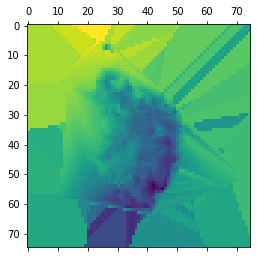

In [126]:
plt.matshow(test_img[:,:,0])

In [14]:
train_gen = generator(data, 72, 0, 0, None, shuffle=True, batch_size=1)
#validation_gen = generator(data_val, 72, 0, 0, None, shuffle=True, batch_size=10)

In [15]:
callbacks_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5
    ),
    ModelCheckpoint(
        filepath='./next_frame_ver2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [16]:
reset_keras()

img_input = Input(shape=(None, 75, 75, 10), name='images')
convlstm2d = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same')(img_input)
batch_norm = layers.BatchNormalization()(convlstm2d)

temp_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='temp')(batch_norm)
wind_dir_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='wind_dir')(batch_norm)
wind_speed_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='wind_speed')(batch_norm)
rainfall_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='rainfall')(batch_norm)
humid_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='humid')(batch_norm)
air_ground_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='air_ground')(batch_norm)
air_sea_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='air_sea')(batch_norm)
all_cloud_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='all_cloud')(batch_norm)
down_cloud_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='down_cloud')(batch_norm)
cloud_height_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='cloud_height')(batch_norm)

model = Model(img_input, [temp_prediction, wind_dir_prediction, wind_speed_prediction, rainfall_prediction, humid_prediction, \
                          air_ground_prediction, air_sea_prediction, all_cloud_prediction, down_cloud_prediction, cloud_height_prediction])

model.compile(optimizer=rmsprop(lr=0.001), loss=['mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae'])
model.summary()

51
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, None, 75, 75, 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 75, 75, 20)   21680       images[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 20)   80          conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
temp (Conv2D)                   (None, 75, 75, 1)    181         batch_normalization_1[0][0]      
__________________________________

In [17]:
history = model.fit_generator(train_gen, #validation_data=validation_gen,
                              steps_per_epoch=20, #validation_steps=20,
                             epochs=1#, callbacks=callbacks_list)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


ValueError: Error when checking target: expected temp to have shape (75, 75, 1) but got array with shape (75, 10, 1)

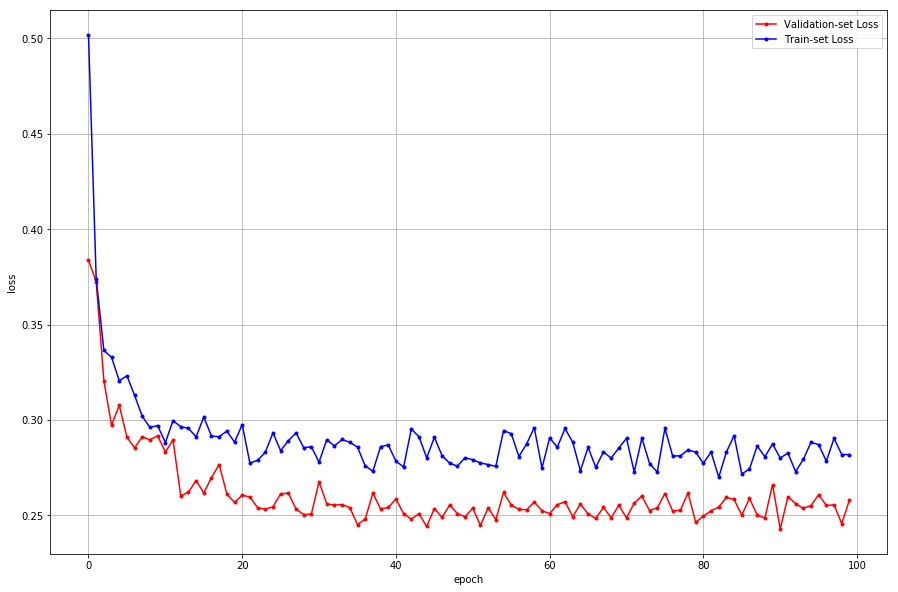

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.figure(figsize=(15, 10))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_val_mae_history = smooth_curve(y_vloss)
smooth_mae_history = smooth_curve(y_loss)

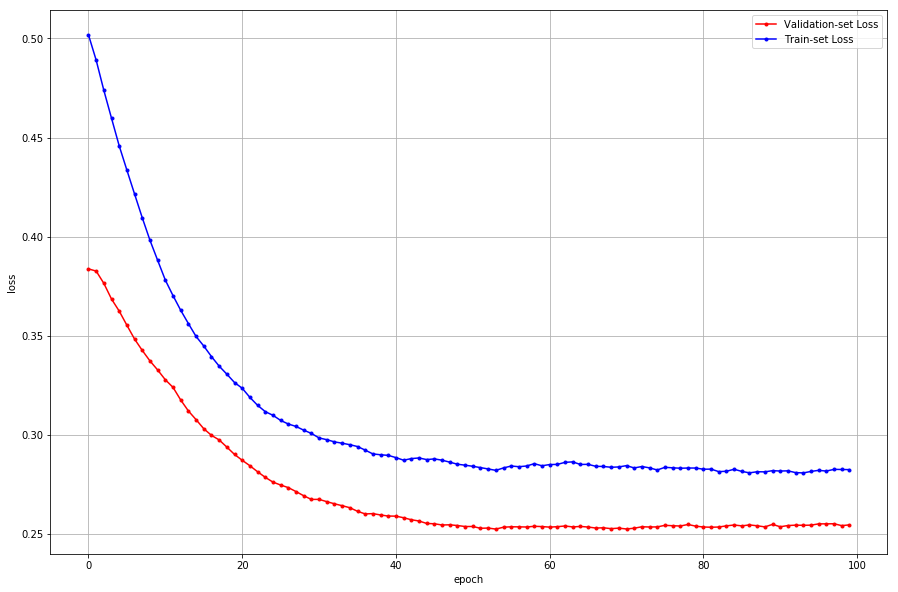

In [ ]:
x_len = np.arange(len(y_loss))
plt.figure(figsize=(15, 10))
plt.plot(x_len, smooth_val_mae_history, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, smooth_mae_history, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
h5f = h5py.File('./drive/My Drive/Colab Notebooks/ver2/next_frame/total_data_ro.h5','r')
data_test = h5f['total_2019'][:]
h5f.close()

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-3], data.shape[-2], data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        return samples, targets

In [ ]:
X_test, y_test = generator(data_test, 72, 0, 0, None, shuffle=True, batch_size=50)

In [ ]:
X_test.shape, y_test.shape

((50, 72, 10, 75, 75), (50, 10, 75, 75))

In [ ]:
model.load_weights('./next_frame.h5')

In [ ]:
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(50, 72, 75, 75, 10)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.rollaxis(y_pred, 3, 1)
y_pred.shape

(50, 10, 75, 75)

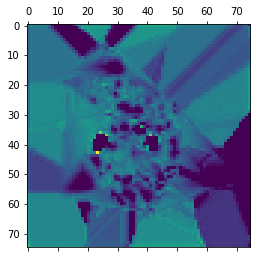

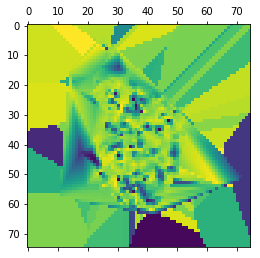

In [ ]:
plt.matshow(y_pred[0][1])
plt.matshow(y_test[0][1])

In [ ]:
y_test[0][3][0]

array([-0.48021886, -0.48021886, -0.48021886, -0.48021886, -0.48021886,
       -0.48021886, -0.48021886, -0.48021886, -0.3989899 , -0.3989899 ,
       -0.3989899 , -0.3989899 , -0.3989899 , -0.3989899 , -0.3989899 ,
        0.75252525,  0.75252525,  0.75252525,  0.75252525,  0.75252525,
        0.75252525,  0.75252525,  0.75252525,  0.75252525,  0.75252525,
        0.75252525,  0.75252525,  0.75252525, -0.31481481, -0.31481481,
       -0.53493266, -0.53493266, -0.53493266, -0.53493266, -0.53493266,
       -0.53493266, -0.5959596 , -0.3989899 , -0.3989899 , -0.3989899 ,
       -0.3989899 , -0.3989899 , -0.3989899 , -0.3989899 , -0.3989899 ,
       -0.3989899 , -0.3989899 , -0.3989899 , -0.3989899 , -0.3989899 ,
       -0.3989899 , -0.56986532, -0.56986532, -0.56986532, -0.56986532,
       -0.56986532, -0.56986532, -0.56986532, -0.56986532, -0.56986532,
       -0.56986532, -0.56986532, -0.56986532, -0.56986532, -0.56986532,
       -0.56986532, -0.56986532, -0.56986532,  0.7209596 ,  0.81

In [ ]:
y_test[1][3][2]

array([ 0.77188552,  0.77188552,  0.77188552,  0.77188552,  0.77188552,
        0.77188552,  0.77188552,  0.77188552,  0.77188552,  0.77188552,
        0.82154882,  0.82154882,  0.82154882,  0.82154882,  0.82154882,
        0.82154882,  0.82154882,  0.82154882,  0.53367003,  0.53367003,
        0.53367003,  0.53367003,  0.53367003,  0.53367003,  0.53367003,
        0.53367003,  0.53367003,  0.44276094,  0.44276094,  0.36069024,
        0.36069024,  0.36069024,  0.36069024,  0.36069024,  0.37710438,
        0.37710438,  0.73737374,  0.73737374,  0.73737374,  0.73737374,
        0.73737374,  0.73737374,  0.73737374,  0.73737374,  0.73737374,
        0.73737374,  0.73737374,  0.73737374,  0.73737374,  0.48106061,
        0.71422559,  0.71422559,  0.71422559,  0.71422559,  0.71422559,
        0.71422559,  0.71422559,  0.71422559,  0.71422559,  0.71422559,
        0.71422559,  0.71422559,  0.71422559,  0.71422559,  0.71422559,
        0.71422559,  0.4212963 , -0.69360269, -0.69360269, -0.69

In [ ]:
data_test[0][0][:][:].shape

(75, 75)

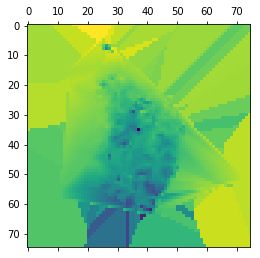

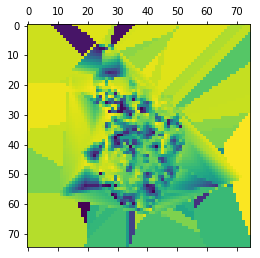

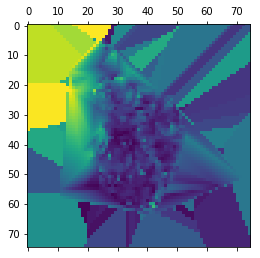

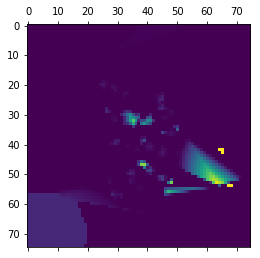

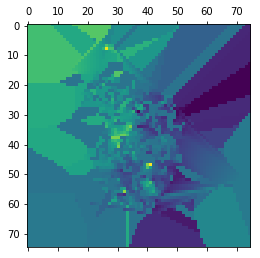

In [ ]:
plt.matshow(y_test[0][0][:][:])
plt.matshow(y_test[0][1][:][:])
plt.matshow(y_test[0][2][:][:])
plt.matshow(y_test[0][3][:][:])
plt.matshow(y_test[0][4][:][:])

In [2]:
list(range(72))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71]